# Shiller Exercise
 
1. Summarize in 3-5 points the key points you think this paper makes.
2. Critique (in no more than 3-5 points) the authors’ conclusions. Which points do you agree/disagree with? What, in your mind, are weak points in the authors’ arguments/analysis?
3. Exercise:
    * Download the attached spreadsheet (chapt26.xlsx).
    * Use Python 3x or Matlab and use the data (up to 1999) in this spreadsheet to replicate the Figure 6 (bottom panel) from the above paper. What are the regression statistics for these plots?
    * Re-plot the above figures using all the available data in the spreadsheet (i.e. up to 2013). What the regression statistics for these plots?
    * What are your key conclusions from these results?
    * Design a two-asset (cash and S&P 500) investment strategy using your conclusions from above. Run a backtest on the strategy and send over the statistics that you think are most relevant to assess the strategy, along with your thoughts on the results.

In [249]:
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [215]:
data = pd.read_excel('/Users/edwardhuang/Documents/Quant Trader/Genna/chapt26.xlsx', sheet_name = 'Data_edit')

In [217]:
# Turn the index, which is the year, into its own column and re-index
data.reset_index(inplace = True)

data['year'] = data['index']
data.drop(columns = 'index', inplace = True)

In [218]:
data.shape

(146, 20)

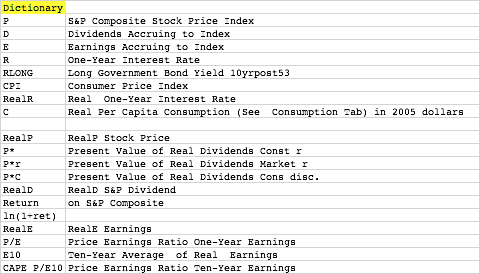

Notes:
- 146 years, 1871 - 2016
- 19 variables

## Task: Replicate Bottom Panel of Figure 6

In [64]:
#10 year Price Growth vs. P/10y MA(E)

In [219]:
# Subset Dataset to only years up to 1999 to create Shiller's old dataset at the time of research
dfa = data[data['year'] <= 1999]

In [220]:
# Create last CPI variable to reset the Real values based on 1999 last year.
last_cpi = dfa[dfa['year'] == 1999].iloc[0]['CPI']

In [221]:
# Recreate the Real Columns for Price and Earnings
dfa['RealP_1999'] = dfa['P'] * last_cpi / dfa['CPI']
dfa['RealE_1999'] = dfa['E'] * last_cpi / dfa['CPI']

In [222]:
# Get the Moving Average of Earnings, 10 years
dfa['E10_1999'] = pd.rolling_mean(dfa, 10)['RealE_1999']

# Get the CAPE, Real Price / E10 over last 10 years. Shift method lags the E10 by 10 years so I don't include the current year's earnings.
dfa['CAPE_1999'] = dfa['RealP_1999'] / dfa['E10_1999'].shift(1)

In [223]:
# Get the change in natural log Price over last 10 years, on a rolling basis
dfa['P_Growth_10_1999'] \
    = dfa['RealP_1999'].shift(-10).apply(lambda x: math.log(x, math.e)) \
    - dfa['RealP_1999'].apply(lambda x: math.log(x, math.e))

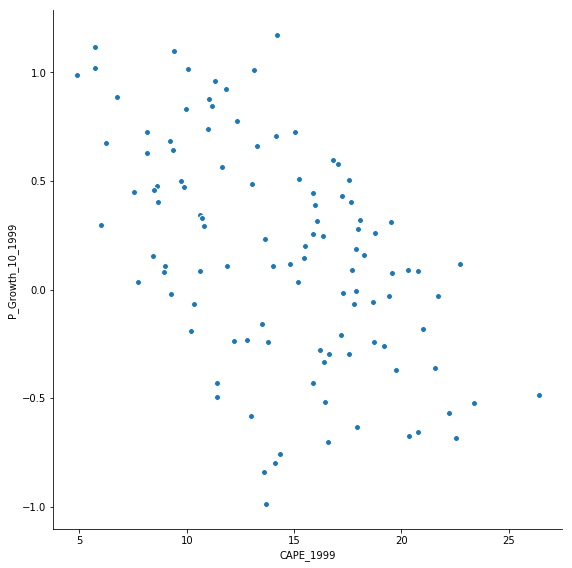

In [224]:
# Plot the scatterplot to check data before running regression
sns.pairplot(dfa, x_vars='CAPE_1999', y_vars='P_Growth_10_1999', size = 8, )

In [225]:
# Transform CAPE into natural log scale
dfa['log_CAPE1999'] = np.log(dfa['CAPE_1999'])

In [226]:
# There are null values because of the Moving Averages (first 10 lines don't have a MA)
# Drop those null values for the regression
dfa.dropna(inplace = True)

In [227]:
X = dfa['log_CAPE1999']
y = dfa['P_Growth_10_1999']

In [230]:
# Must reshape the matrix into 1 row each for regression
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [231]:
# Instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

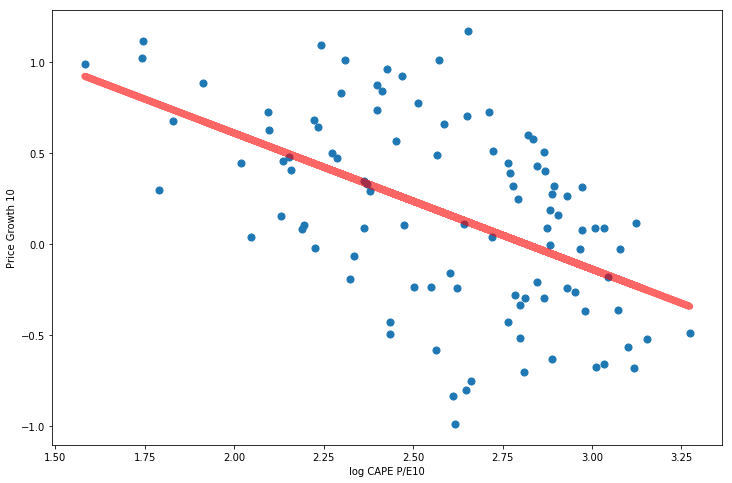

In [77]:
#Make predictions by passing X into model
preds = linreg.predict(X)

#Set plot size to (12,8)
plt.figure(figsize=(12, 8))
#Make scatter of X and y
plt.scatter(X,y, s = 50)
#Make line plot of X and preds
plt.plot(X, preds, "r", linewidth= 7, alpha = .6)
plt.xlabel("log CAPE P/E10")
plt.ylabel("Price Growth 10");

In [78]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

[2.10701915]
[[-0.74841528]]


In [79]:
print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

Mean squared error: 0.20
Variance score: 0.27


Formal Regression Equation: 
y = 2.1 - 0.75x

The explained variance is 27%

## Task: Re-plot the above figures using all the available data in the spreadsheet (i.e. up to 2013).

In [232]:
# Change dataset up to 2013
dfb = data[data['year'] <= 2013]

In [233]:
# Update the last CPI
last_cpi = dfb[dfb['year'] == 2013].iloc[0]['CPI']

In [82]:
# Run the same process, same code as before but updated Datatable and Last CPI variable above:

dfb['RealP_1999'] = dfb['P'] * last_cpi / dfb['CPI']
dfb['RealE_1999'] = dfb['E'] * last_cpi / dfb['CPI']

dfb['E10_1999'] = pd.rolling_mean(dfb, 10)['RealE_1999']
dfb['CAPE_1999'] = dfb['RealP_1999'] / dfb['E10_1999'].shift(1)

dfb['P_Growth_10_1999'] \
    = dfb['RealP_1999'].shift(-10).apply(lambda x: math.log(x, math.e)) \
    - dfb['RealP_1999'].apply(lambda x: math.log(x, math.e))

dfb['log_CAPE1999'] = np.log(dfb['CAPE_1999'])

dfb.dropna(inplace = True)

X = dfb['log_CAPE1999']
y = dfb['P_Growth_10_1999']

X = X.reshape(-1,1)
y = y.reshape(-1,1)

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

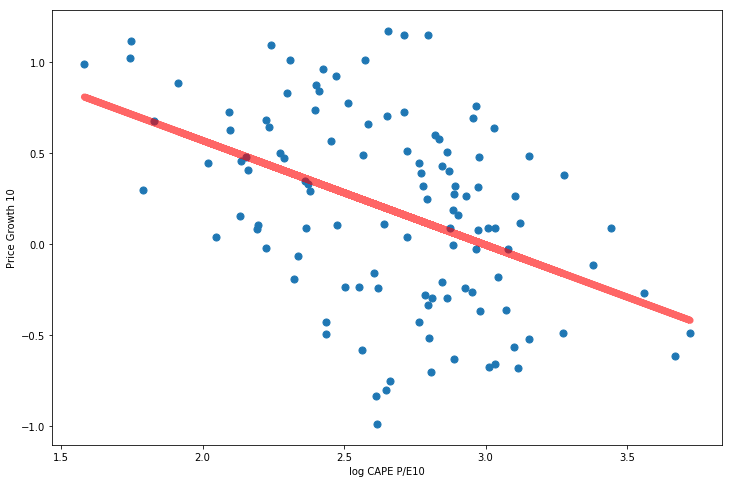

In [83]:
# Run the plot again, same code as before
preds = linreg.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X,y, s = 50)
plt.plot(X, preds, "r", linewidth= 7, alpha = .6)
plt.xlabel("log CAPE P/E10")
plt.ylabel("Price Growth 10");

In [84]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

[1.71697049]
[[-0.5738804]]
Mean squared error: 0.22
Variance score: 0.20


## What are your key conclusions from these results?

MSE increased and Explained Variance decreased for the model in the years between 1999 and 2013.

The drop from .27 to .20 in R^2 suggests that the CAPE ratio has had less ability to predict market Price movement over the last 15 or so years. The question that arises from this observation is whether this is a temporary departure or if we have encountered a regime shift.

Regime shift possible explanations are included in the critiques in the attached Word Doc.

## Design a two-asset (cash and S&P 500) investment strategy using your conclusions from above. 

Benchmark: S&P 500
Asset Allocation Strategy:
- 50% equity/ 50% cash when CAPE within 25%/75% bounds
- 75% equity/ 25% cash when CAPE below 25% bound
- 25% equity, 75% cash when CAPE above 75% bound

yearly intervals

In [234]:
normal = .5
low = .25
high = .75

In [235]:
strat['CAPE_lower_bound'] = strat['CAPE P/E10'].quantile(q = 0.25)
strat['CAPE_upper_bound'] = strat['CAPE P/E10'].quantile(q = 0.75)

In [236]:
def weighted_sp500(strat):
    pct_growth = strat['Return']
    
    if strat['CAPE P/E10'] < strat['CAPE_lower_bound']:
        return 1 + (high * pct_growth)
    elif strat['CAPE P/E10'] > strat['CAPE_upper_bound']:
        return 1 + (low * pct_growth)
    else:
        return 1 + (normal * pct_growth)

In [237]:
def category(strat):
    if strat['CAPE P/E10'] < strat['CAPE_lower_bound']:
        return 1
    elif strat['CAPE P/E10'] > strat['CAPE_upper_bound']:
        return -1
    else:
        return 0

In [238]:
strat['return'] = strat.apply(weighted_sp500, axis = 1)
strat['category'] = strat.apply(category, axis = 1)

In [239]:
strat['running_return'] = strat['return'].cumprod()
strat['sp500_running_return'] = strat['Return'].apply(lambda x: x+1).cumprod()

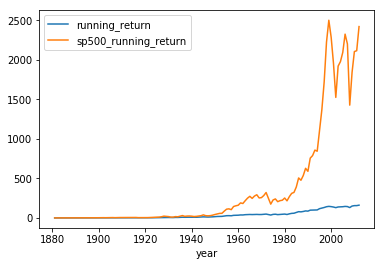

In [240]:
strat.plot(x = 'year', y = ['running_return', 'sp500_running_return'])

Not a fair visualization because we had set 50/50 allocation when CAPE between lower and upper bound. When I have more time I will compare this strategy to a 50% equity, 50% cash benchmark.

## Run a backtest on the strategy and send over the statistics that you think are most relevant to assess the strategy, along with your thoughts on the results.

Instead of using the 25% and 75% bounds as fixed numbers for all time, why don't you do a MA for 20 years (arbitrarily picked) to try to keep CAPE updated and avoid the regime differences within the 100+ years time frame.

In [244]:
# MA timeframe
window = 20

In [245]:
strat['CAPE_lower_bound'] = strat.rolling(window=window,center=False).quantile(0.25)['CAPE P/E10']
strat['CAPE_upper_bound'] = strat.rolling(window=window,center=False).quantile(0.75)['CAPE P/E10']

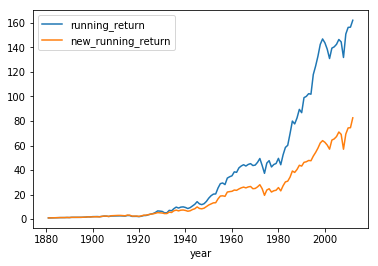

In [246]:
strat['new_return'] = strat.apply(weighted_sp500, axis = 1)
strat['new_category'] = strat.apply(category, axis = 1)
strat['new_running_return'] = strat['new_return'].cumprod()
strat.plot(x = 'year', y = ['running_return', 'new_running_return'])

New Strategy underperformed its old strategy benchmark.

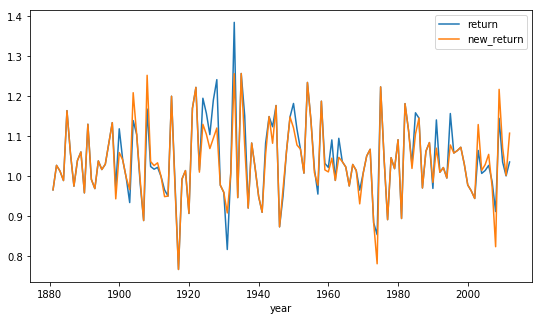

In [247]:
strat.plot(x = 'year', y = ['return', 'new_return'], figsize = (9,5))

Volatility of its returns looks to be about the same.

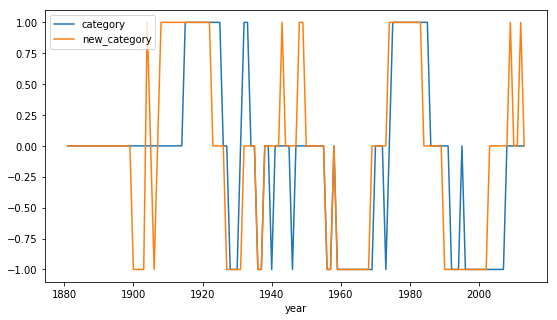

In [201]:
strat.plot(x = 'year', y = ['category', 'new_category'], figsize = (9,5))

Here are the time frames where the underweight/overweight categories strayed from each other.

How to assess the strategy:
- Total Return Compared to Benchmark (using historical CAPE quantile bounds)
- Total Return split by timeframe (we think there was a regime shift post 1999, as seen in our model's decrease in R^2 from 1999 to 2013)
- Stress Test: see performance only when the two strategies diverge to avoid only looking at bigger picture which can be skewed by compounding of previous returns
- Number of trades
- Measure volatility
- Drawdown stats (max drawdown)
- Correlation to benchmark
- Sharpe Ratio, t-stat, number of standard deviations away from 0 profitability
- Test strategy with other indices including other countries'
    - Testing against lower correlated indices is good to see how it performs


Other Ideas:
- Make adjustments to CAPE based on Accounting standard switch
- Instead of fixed weightings, make them more incremental based on how far CAPE is into undervalued/overvalued territory


Would be nice to have color gradient on the Returns chart to show signal for price movement